# NEON Canopy Height Model to Biomass at Niwot Ridge

## Applying the NEON tutorial from SJER to NIWO

The code in this notebook is taken and adapted from: 
https://www.neonscience.org/resources/learning-hub/tutorials/calc-biomass-py

"In this tutorial, we will calculate the biomass for a section of the SJER site. We will be using the Canopy Height Model discrete LiDAR data product as well as field data collected by the TOS group at NEON. This tutorial will calculate Biomass for individual trees in the forest."

SJER = San Joaquin Experimental Range

NIWO = Niwot Ridge Mountain Research Station

In [1]:
# Import libraries
import numpy as np
import os
import gdal, osr
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

# Import biomass specific libraries
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Define plot band array function
def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

# Define a function that will allow us to output GeoTIFF files.
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()


In [3]:
# Define a path to the CHM file 
chm_file = './data/NEON_D13_NIWO_DP3_452000_4432000_CHM.tif'

In [4]:
# Get info from CHM file for outputting results
just_chm_file = os.path.basename(chm_file)
just_chm_file_split = just_chm_file.split(sep="_")

In [5]:
# Open the CHM file with GDAL
chm_dataset = gdal.Open(chm_file)

# Get the raster band object
chm_raster = chm_dataset.GetRasterBand(1)

# Get the NO DATA value
noDataVal_chm = chm_raster.GetNoDataValue()

# Get required metadata from CHM file
cols_chm = chm_dataset.RasterXSize
rows_chm = chm_dataset.RasterYSize
bands_chm = chm_dataset.RasterCount
mapinfo_chm =chm_dataset.GetGeoTransform()
xMin = mapinfo_chm[0]
yMax = mapinfo_chm[3]
xMax = xMin + chm_dataset.RasterXSize/mapinfo_chm[1]
yMin = yMax + chm_dataset.RasterYSize/mapinfo_chm[5]
image_extent = (xMin,xMax,yMin,yMax)

In [26]:
# Find min and max height values in the CHM image 
chm_stats = chm_raster.ComputeStatistics(0)
chm_metadata = chm_raster.GetMetadata()


chm_min_height = chm_stats[0]
chm_max_height = chm_stats[1]

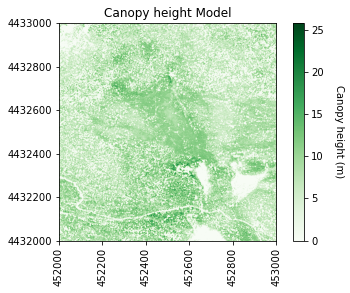

In [27]:
# Plot the original CHM
plt.figure(1)
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)

# Plot the CHM figure
plot_band_array(chm_array,image_extent,'Canopy height Model','Canopy height (m)','Greens',[chm_min_height, chm_max_height])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'CHM.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)